<link href="https://fonts.googleapis.com/css2?family=Montserrat:wght@700&display=swap" rel="stylesheet">

<div style="text-align: center; font-family: 'Roboto', sans-serif; padding: 20px; font-size: 36px; font-weight: bold; color: #FF5733;">
  FOOD CLASSIFICATION
</div>


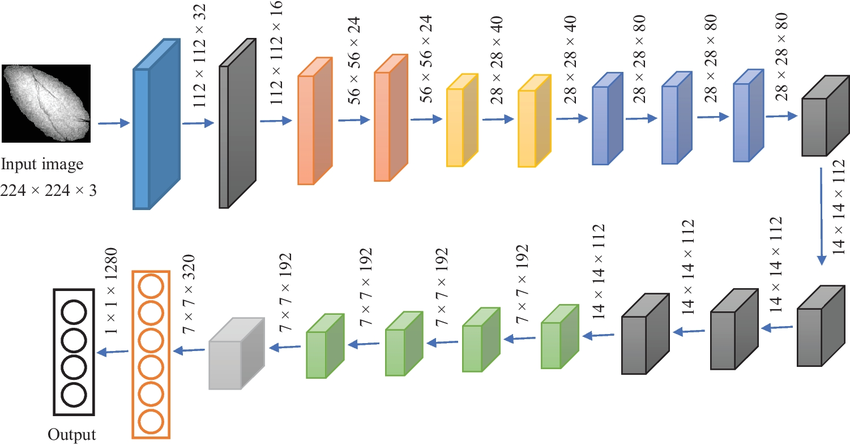

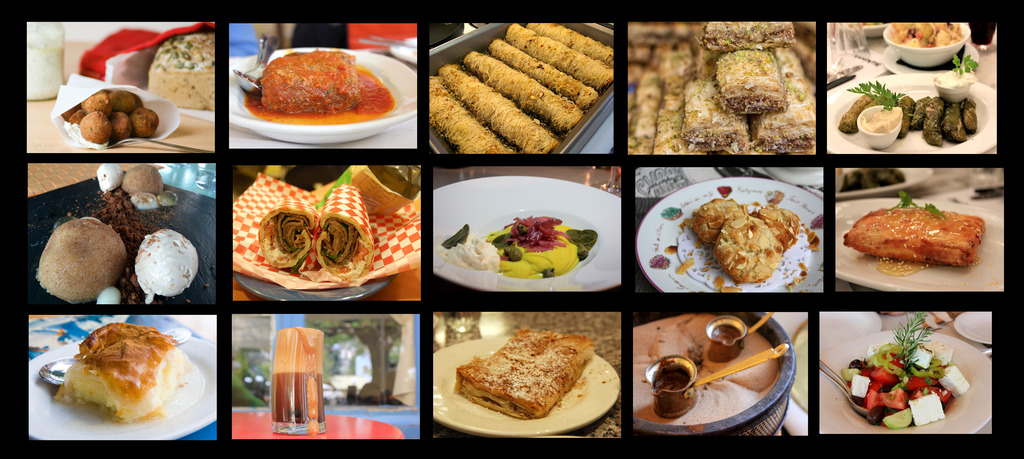

<link href="https://fonts.googleapis.com/css2?family=Montserrat:wght@700&display=swap" rel="stylesheet">

<div style="font-family: 'Roboto', sans-serif; padding: 20px; line-height: 1.6; color: #333;">

  <p style="font-size: 18px; font-weight: 300;">
    The Food Classification project is a deep learning model initiative focused on accurately classifying different types of food from images. By utilizing the comprehensive Food-101 dataset, consisting of 101,000 images across 101 food classes, this project aims to advance image analysis in the context of food recognition using cutting-edge deep learning models.
  </p>

  <h2 style="color: #FF5733; font-size: 22px; font-weight: bold;">Dataset Overview</h2>
  <ul style="font-size: 18px; font-weight: 400; margin-left: 20px;">
    <li><strong>Total Images:</strong> 101,000</li>
    <li><strong>Number of Training Images:</strong> 75,750</li>
    <li><strong>Number of Test Images:</strong> 25,250</li>
    <li><strong>Number of Classes:</strong> 101</li>
  </ul>

  <h2 style="color: #FF5733; font-size: 22px; font-weight: bold;">Technical Approach</h2>
  <ul style="font-size: 18px; font-weight: 400; margin-left: 20px;">
    <li><strong>Model Architecture:</strong> EfficientNet-B0</li>
    <li><strong>Classifier Layers:</strong> Custom linear layer for 101-class classification</li>
    <li><strong>Input Shape:</strong> 224x224x3</li>
    <li><strong>Output:</strong> 101-class softmax layer for food category prediction</li>
    <li><strong>Training Epochs:</strong> 10</li>
  </ul>

</div>


<div style="text-align: center; font-family: 'Roboto', sans-serif; padding: 20px; font-size: 36px; font-weight: bold; color: #FF5733;">
  BUSINESS CASE
</div>

The Food Classification project harnesses deep learning and computer vision technologies to meet the increasing demand for accurate and automated food recognition across various industries. In the food delivery and restaurant sectors, it enables quick identification of dishes for efficient ordering, inventory management, and personalized recommendations. Healthcare and nutrition platforms can leverage it to analyze dietary habits, promoting healthier eating by tracking food intake. It also benefits social media platforms and apps, where food enthusiasts can easily categorize and share food content. Additionally, grocery retailers can use it for product identification, enhancing online shopping experiences and providing targeted marketing based on dietary preferences.


<div style="text-align: left; font-family: 'Roboto', sans-serif; padding: 20px; font-size: 30px; font-weight: bold; color: #FF5733;">
  Dataset Download CMD
</div>


In [ ]:
import requests
from tqdm import tqdm

# URL of the dataset
url = "https://d3ilbtxij3aepc.cloudfront.net/projects/CNN-PROJECT-1-6/food-101.zip"
local_filename = "food-101.zip"

def download_file(url):
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        total_size = int(r.headers.get('content-length', 0))
        with open(local_filename, 'wb') as f, tqdm(
            desc=local_filename,
            total=total_size,
            unit='iB',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
                bar.update(len(chunk))

# Call the download function
download_file(url)


food-101.zip: 100%|██████████| 4.78G/4.78G [00:54<00:00, 93.8MiB/s]


In [ ]:
import zipfile
import os

# Path file
zip_file_path = '/content/food-101.zip'
# Directory to extract 
extract_dir = '/content/food-101/images'

# Create a directory 
os.makedirs(extract_dir, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted to: {extract_dir}")


Extracted to: /content/food-101/images


In [ ]:
import os
import h5py
import numpy as np
from PIL import Image
import json
from tqdm import tqdm

# Define constants
DATASET_PATH = "/content/food-101"
OUTPUT_PATH = "/content/food-101"
META_PATH = "/content/food-101/meta/meta"

def load_image(image_path, size, grayscale=False):
    try:
        with Image.open(image_path) as img:
            if grayscale:
                img = img.convert('L')
            else:
                img = img.convert('RGB')
            img = img.resize((size, size))
        return np.array(img)
    except Exception as e:
        print(f"Error loading image {image_path}: {str(e)}")
        return None

def create_h5_file(file_path, images, labels):
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    with h5py.File(file_path, 'w') as f:
        f.create_dataset('images', data=images)
        f.create_dataset('labels', data=labels)

def process_dataset(image_files, labels, output_file, size, channels):
    images = []
    valid_labels = []
    for img_file, label in tqdm(zip(image_files, labels), desc=f"Processing {output_file}", total=len(image_files)):
        img = load_image(img_file, size, grayscale=(channels==1))
        if img is not None:
            images.append(img)
            valid_labels.append(label)

    images = np.array(images)
    if channels == 1:
        images = images[..., np.newaxis]

    create_h5_file(output_file, images, valid_labels)

def create_meta_files(class_names, train_data, test_data):
    os.makedirs(META_PATH, exist_ok=True)

    # Create classes.txt and labels.txt
    with open(os.path.join(META_PATH, 'classes.txt'), 'w') as f:
        f.write('\n'.join(class_names))

    with open(os.path.join(META_PATH, 'labels.txt'), 'w') as f:
        f.write('\n'.join(str(i) for i in range(len(class_names))))

    # Create train.txt, test.txt, train.json, and test.json
    for split, data in [('train', train_data), ('test', test_data)]:
        with open(os.path.join(META_PATH, f'{split}.txt'), 'w') as f:
            f.write('\n'.join(f"{img_path} {label}" for img_path, label in data))

        json_data = [{"image_name": os.path.basename(img_path), "label": label} for img_path, label in data]
        with open(os.path.join(META_PATH, f'{split}.json'), 'w') as f:
            json.dump(json_data, f, indent=2)

# Main execution
if __name__ == "__main__":
    # Create output directories
    os.makedirs(OUTPUT_PATH, exist_ok=True)
    os.makedirs(META_PATH, exist_ok=True)

    # Load class names
    class_names = sorted(os.listdir(os.path.join(DATASET_PATH, 'images')))
    class_to_label = {cls: i for i, cls in enumerate(class_names)}

    # Prepare data
    train_data = []
    test_data = []
    for cls in class_names:
        img_dir = os.path.join(DATASET_PATH, 'images', cls)
        img_files = [os.path.join(img_dir, f) for f in os.listdir(img_dir)]
        label = class_to_label[cls]

        train_data.extend([(f, label) for f in img_files[:900]])
        test_data.extend([(f, label) for f in img_files[900:1000]])

    # Create h5 files
    configs = [
        ("food_c101_n1000_r384x384x3.h5", 1000, 384, 3),
        ("food_c101_n10099_r32x32x1.h5", 10099, 32, 1),
        ("food_c101_n10099_r32x32x3.h5", 10099, 32, 3),
        ("food_c101_n10099_r64x64x1.h5", 10099, 64, 1),
        ("food_c101_n10099_r64x64x3.h5", 10099, 64, 3),
        ("food_test_c101_n1000_r128x128x1.h5", 1000, 128, 1),
        ("food_test_c101_n1000_r128x128x3.h5", 1000, 128, 3),
        ("food_test_c101_n1000_r32x32x1.h5", 1000, 32, 1),
        ("food_test_c101_n1000_r32x32x3.h5", 1000, 32, 3),
        ("food_test_c101_n1000_r64x64x1.h5", 1000, 64, 1),
        ("food_test_c101_n1000_r64x64x3.h5", 1000, 64, 3),
    ]

    for file_name, n_samples, size, channels in configs:
        output_file = os.path.join(OUTPUT_PATH, file_name)
        if "test" in file_name:
            data = test_data[:n_samples]
        else:
            data = train_data[:n_samples]

        image_files, labels = zip(*data)
        process_dataset(image_files, labels, output_file, size, channels)

    # Create meta files
    create_meta_files(class_names, train_data, test_data)

print("Dataset processing completed.")

Processing /content/food-101/food_c101_n1000_r384x384x3.h5: 100%|██████████| 1000/1000 [00:07<00:00, 132.60it/s]
Processing /content/food-101/food_c101_n10099_r32x32x1.h5: 100%|██████████| 10099/10099 [00:46<00:00, 215.18it/s]
Processing /content/food-101/food_c101_n10099_r32x32x3.h5: 100%|██████████| 10099/10099 [00:37<00:00, 267.41it/s]
Processing /content/food-101/food_c101_n10099_r64x64x1.h5: 100%|██████████| 10099/10099 [00:29<00:00, 347.60it/s]
Processing /content/food-101/food_c101_n10099_r64x64x3.h5: 100%|██████████| 10099/10099 [00:39<00:00, 256.77it/s]
Processing /content/food-101/food_test_c101_n1000_r128x128x1.h5: 100%|██████████| 1000/1000 [00:03<00:00, 315.84it/s]
Processing /content/food-101/food_test_c101_n1000_r128x128x3.h5: 100%|██████████| 1000/1000 [00:05<00:00, 199.70it/s]
Processing /content/food-101/food_test_c101_n1000_r32x32x1.h5: 100%|██████████| 1000/1000 [00:02<00:00, 386.19it/s]
Processing /content/food-101/food_test_c101_n1000_r32x32x3.h5: 100%|██████████|

Dataset processing completed.


<div style="text-align: left; font-family: 'Roboto', sans-serif; padding: 20px; font-size: 30px; font-weight: bold; color: #FF5733;">
  Assignining Directories
</div>


In [ ]:
import os
import json
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import warnings
warnings.filterwarnings("ignore")


# Set paths
BASE_PATH = '/content/food-101'
META_PATH = os.path.join(BASE_PATH, 'meta', 'meta')  # Note the double 'meta'
IMAGES_PATH = os.path.join(BASE_PATH, 'images')

# Verify paths
print(f"BASE_PATH: {BASE_PATH}")
print(f"META_PATH: {META_PATH}")
print(f"IMAGES_PATH: {IMAGES_PATH}")

BASE_PATH: /content/food-101
META_PATH: /content/food-101/meta/meta
IMAGES_PATH: /content/food-101/images


<div style="text-align: left; font-family: 'Roboto', sans-serif; padding: 20px; font-size: 30px; font-weight: bold; color: #FF5733;">
  Load Class Information
</div>

We will load class information from the `classes.txt` and `labels.txt` files to understand the dataset's class structure.

In [ ]:
def load_class_info():
    with open(os.path.join(META_PATH, 'classes.txt'), 'r') as f:
        classes = [line.strip() for line in f]
    with open(os.path.join(META_PATH, 'labels.txt'), 'r') as f:
        labels = [line.strip() for line in f]
    return dict(zip(classes, labels))

# Load class information
class_info = load_class_info()
print(f'Number of classes: {len(class_info)}')

Number of classes: 101


<div style="text-align: left; font-family: 'Roboto', sans-serif; padding: 20px; font-size: 30px; font-weight: bold; color: #FF5733;">
  Analyse Image distribution
</div>

We'll analyze the distribution of images across different classes for both training and test datasets.

Number of training images: 75750


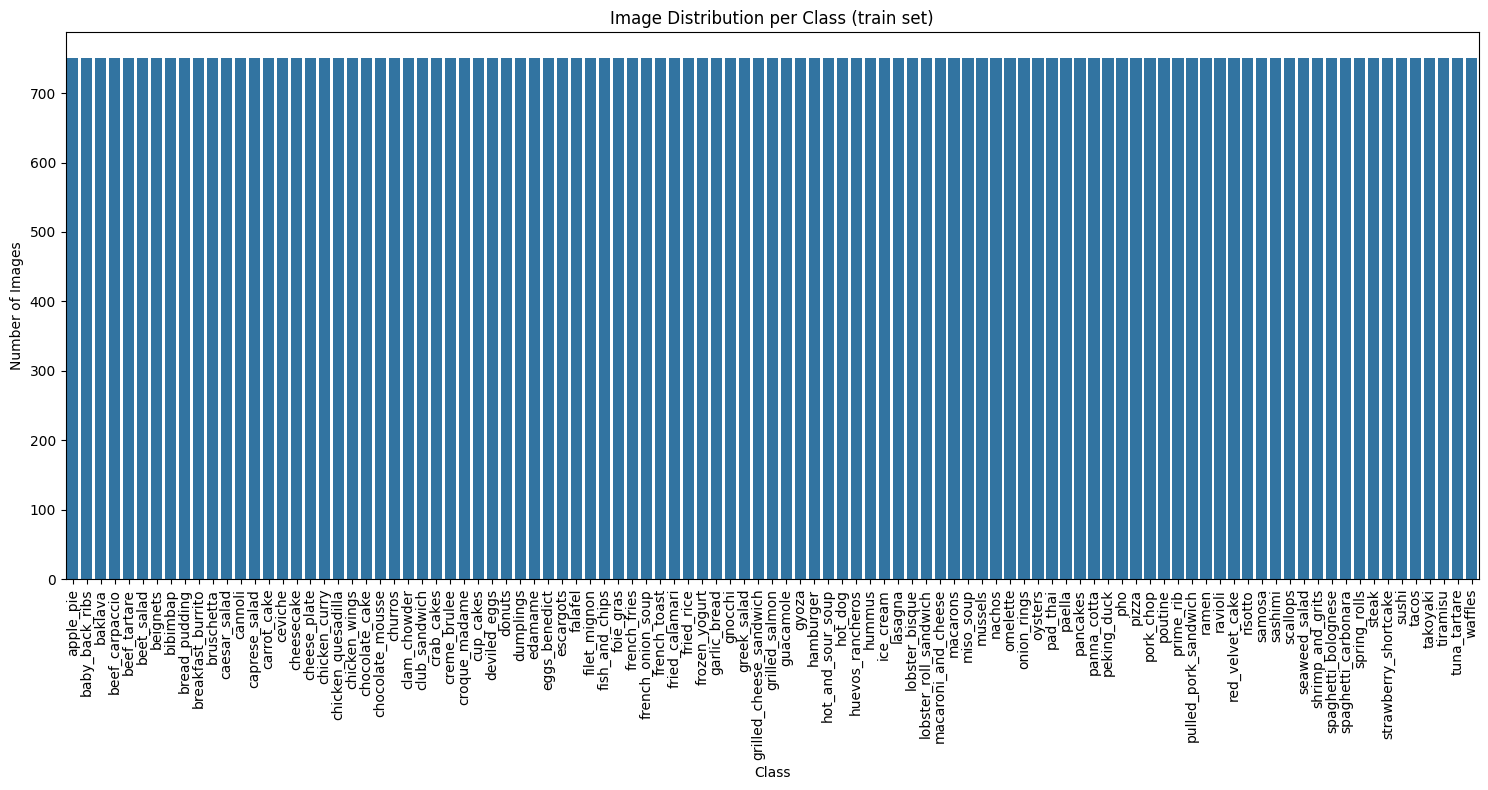

Number of test images: 25250


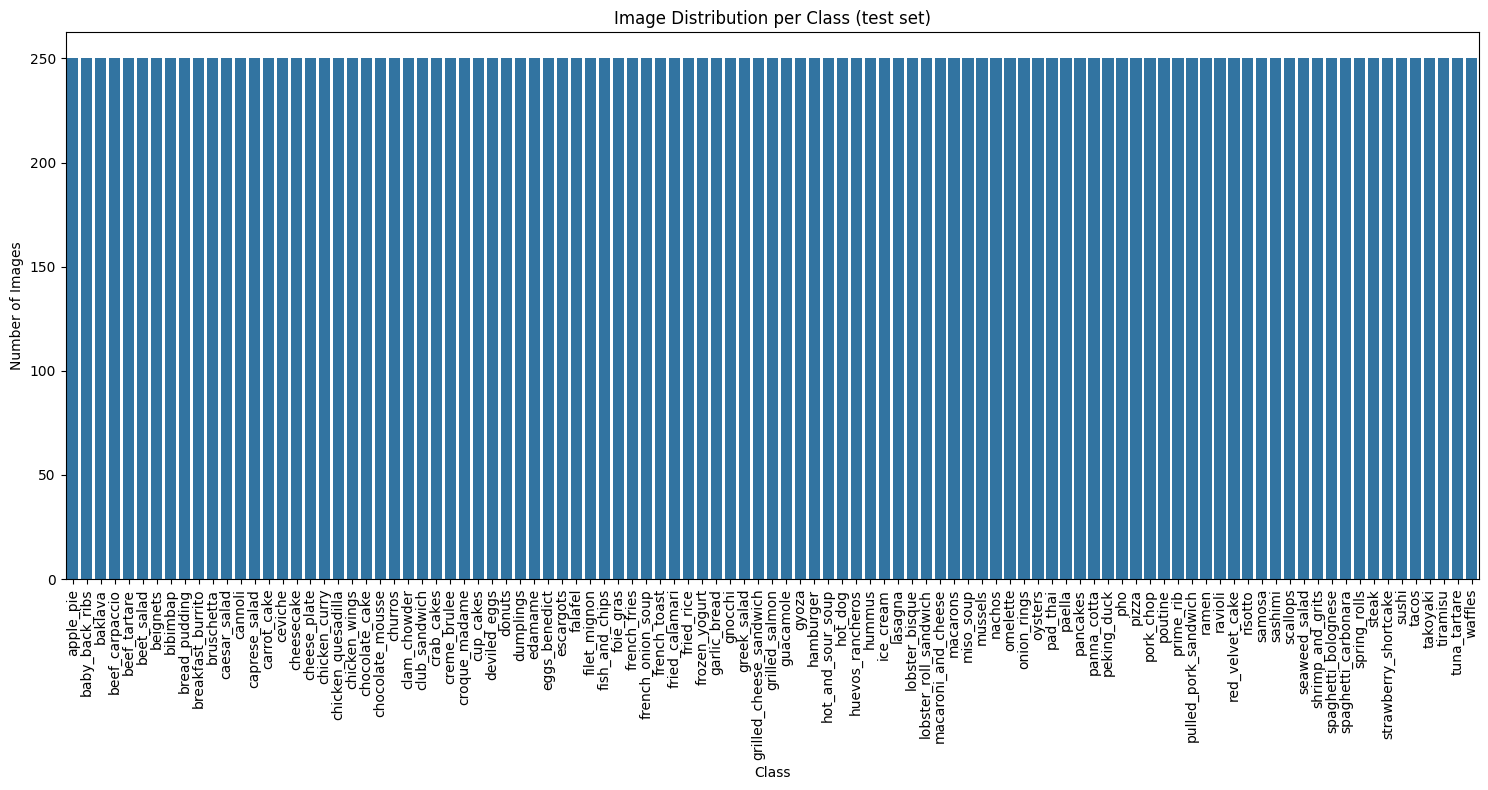

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Define constants
META_PATH = "/content/food-101/meta/meta"

def load_split_data(split):
    with open(os.path.join(META_PATH, f'{split}.txt'), 'r') as f:
        return [line.strip().split(' ') for line in f]  # Ensure correct split by space

def analyze_image_distribution(split_data, class_info, split):
    class_counts = {}

    # Count occurrences of each class
    for _, class_label in split_data:  # Unpacking file path and label
        class_name = class_info[int(class_label)]  # Convert label to class name using class_info
        class_counts[class_name] = class_counts.get(class_name, 0) + 1

    # Plotting distribution
    plt.figure(figsize=(15, 8))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    plt.xticks(rotation=90)
    plt.title(f'Image Distribution per Class ({split} set)')
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.tight_layout()
    plt.show()

# Load class info
def load_class_info():
    with open(os.path.join(META_PATH, 'classes.txt'), 'r') as f:
        return [line.strip() for line in f]

# Main execution
class_info = load_class_info()

# Analyze train set
train_data = load_split_data('train')
print(f'Number of training images: {len(train_data)}')
analyze_image_distribution(train_data, class_info, 'train')

# Analyze test set
test_data = load_split_data('test')
print(f'Number of test images: {len(test_data)}')
analyze_image_distribution(test_data, class_info, 'test')


## Analyze Image Sizes
We will inspect the sizes of a sample of images to understand the variability in image dimensions.

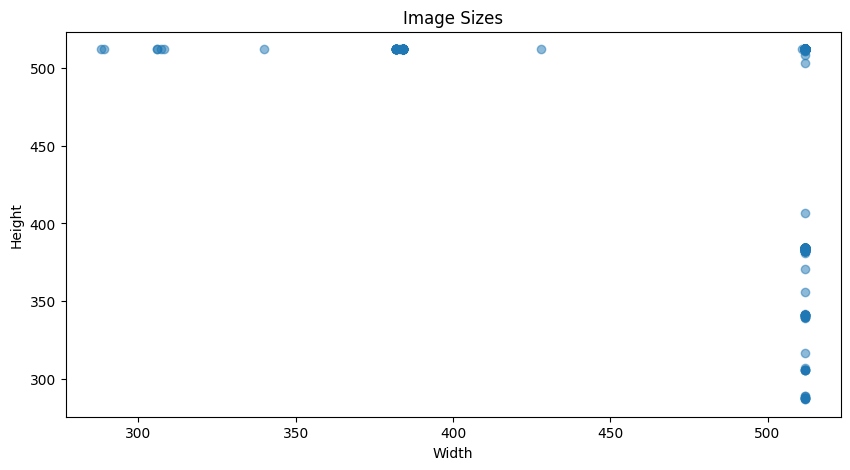

In [ ]:
def analyze_image_sizes():
    sizes = []
    for root, _, files in os.walk(IMAGES_PATH):
        for file in files[:5]:  # Limit to 1000 images for efficiency
            if file.endswith('.jpg'):
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    sizes.append(img.size)

    widths, heights = zip(*sizes)
    plt.figure(figsize=(10, 5))
    plt.scatter(widths, heights, alpha=0.5)
    plt.title('Image Sizes')
    plt.xlabel('Width')
    plt.ylabel('Height')
    plt.show()

# Analyze image sizes
analyze_image_sizes()

## Analyze H5 Files
Finally, we will inspect the `.h5` files to understand the datasets and their structure.

In [ ]:
def analyze_h5_files():
    h5_files = [f for f in os.listdir(BASE_PATH) if f.endswith('.h5')]
    for h5_file in h5_files:
        with h5py.File(os.path.join(BASE_PATH, h5_file), 'r') as f:
            print(f"\nFile: {h5_file}")
            print("Datasets:")
            for key in f.keys():
                dataset = f[key]
                print(f"  {key}: shape={dataset.shape}, dtype={dataset.dtype}")

# Analyze H5 files
analyze_h5_files()


File: food_c101_n10099_r64x64x1.h5
Datasets:
  category: shape=(10099, 101), dtype=bool
  category_names: shape=(101,), dtype=|S40
  images: shape=(10099, 64, 64, 1), dtype=float64

File: food_test_c101_n1000_r64x64x3.h5
Datasets:
  category: shape=(1000, 101), dtype=bool
  category_names: shape=(101,), dtype=|S40
  images: shape=(1000, 64, 64, 3), dtype=uint8

File: food_test_c101_n1000_r32x32x3.h5
Datasets:
  category: shape=(1000, 101), dtype=bool
  category_names: shape=(101,), dtype=|S40
  images: shape=(1000, 32, 32, 3), dtype=uint8

File: food_test_c101_n1000_r128x128x3.h5
Datasets:
  category: shape=(1000, 101), dtype=bool
  category_names: shape=(101,), dtype=|S40
  images: shape=(1000, 128, 128, 3), dtype=uint8

File: food_c101_n10099_r32x32x3.h5
Datasets:
  category: shape=(10099, 101), dtype=bool
  category_names: shape=(101,), dtype=|S40
  images: shape=(10099, 32, 32, 3), dtype=uint8

File: food_c101_n10099_r64x64x3.h5
Datasets:
  category: shape=(10099, 101), dtype=bool

# Food41 Image Classification
In this notebook, we will train an EfficientNet-B0 model on the Food41 dataset. We will go through the process of data preparation, model training, evaluation, and testing.

In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.models import EfficientNet_B0_Weights
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
from tqdm.auto import tqdm

## Device Setup
We will use a GPU if available; otherwise, we will fall back to the CPU.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Paths and Loading
Specify paths to the dataset and load class information.

In [ ]:
with open(os.path.join(META_PATH, 'classes.txt'), 'r') as f:
    classes = [line.strip() for line in f]
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

## Custom Dataset Class
Define a custom dataset class for loading images and their labels.

In [ ]:
class Food41Dataset(Dataset):
    def __init__(self, txt_file, transform=None):
        with open(txt_file, 'r') as f:
            self.img_labels = [line.strip().split() for line in f]
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path, label = self.img_labels[idx]
        img_path = os.path.join(IMAGES_PATH, img_path)

        if not os.path.exists(img_path):
            print(f"File not found: {img_path}")
            # You might want to return a default image or skip this item
            # For now, we'll raise the error to make it obvious during debugging
            raise FileNotFoundError(f"No such file: {img_path}")

        image = Image.open(img_path).convert('RGB')
        label = int(label)  # Assuming labels are integers

        if self.transform:
            image = self.transform(image)

        return image, label


###  Transformations for the training, validation, and testing datasets.

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## Data Preparation split  into training and validation sets.

In [ ]:
with open(os.path.join(META_PATH, 'train.txt'), 'r') as f:
    all_train_data = [line.strip() for line in f]

# Shuffle the data
random.shuffle(all_train_data)

# Split into train and validation (e.g., 80% train, 20% validation)
split = int(0.8 * len(all_train_data))
train_data = all_train_data[:split]
val_data = all_train_data[split:]

# Write train and validation data to temporary files
with open('temp_train.txt', 'w') as f:
    f.write('\n'.join(train_data))

with open('temp_val.txt', 'w') as f:
    f.write('\n'.join(val_data))

## Create Datasets and Data Loaders
Create data loaders for training, validation, and testing datasets.

In [ ]:
train_dataset = Food41Dataset('temp_train.txt', transform=train_transform)
val_dataset = Food41Dataset('temp_val.txt', transform=val_test_transform)
test_dataset = Food41Dataset(os.path.join(META_PATH, 'test.txt'), transform=val_test_transform)

batch_size = 300
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True)

<div style="text-align: left; font-family: 'Roboto', sans-serif; padding: 20px; font-size: 28px; font-weight: bold; color: #FF5733;">
 Model Setup -EfficientNet-B0
</div>

In [ ]:
model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, len(classes))
model = nn.DataParallel(model).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:01<00:00, 20.0MB/s]


### Loss Function and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

# Initialize the GradScaler
scaler = GradScaler()

<ipython-input-18-13e8da1147c2>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


## Training Function

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    best_acc = 0.0
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            pbar = tqdm(dataloader, desc=f'{phase.capitalize()} Epoch {epoch+1}/{num_epochs}')
            for inputs, labels in pbar:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    with autocast():
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                pbar.set_postfix({'loss': loss.item(), 'acc': torch.sum(preds == labels.data).double() / inputs.size(0)})

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())
                scheduler.step(epoch_loss)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'best_model.pth')

        print()

    return model, train_losses, train_accs, val_losses, val_accs

<div style="text-align: left; font-family: 'Roboto', sans-serif; padding: 20px; font-size: 30px; font-weight: bold; color: #FF5733;">
  Model Training
</div>

Train the model using the previously defined function.

In [ ]:
num_epochs=10
model, train_losses, train_accs, val_losses, val_accs = train_model(model, criterion, optimizer, scheduler, num_epochs)

Epoch 1/10
----------


Train Epoch 1/10:   0%|          | 0/202 [00:00<?, ?it/s]

train Loss: 2.2142 Acc: 0.4692


Val Epoch 1/10:   0%|          | 0/51 [00:00<?, ?it/s]

val Loss: 1.1798 Acc: 0.6875

Epoch 2/10
----------


Train Epoch 2/10:   0%|          | 0/202 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3cd40397e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3cd40397e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

train Loss: 1.4813 Acc: 0.6203


Val Epoch 2/10:   0%|          | 0/51 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3cd40397e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3cd40397e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

val Loss: 1.0020 Acc: 0.7364

Epoch 3/10
----------


Train Epoch 3/10:   0%|          | 0/202 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3cd40397e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3cd40397e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

train Loss: 1.2971 Acc: 0.6639


Val Epoch 3/10:   0%|          | 0/51 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3cd40397e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


val Loss: 0.9402 Acc: 0.7560

Epoch 4/10
----------


Train Epoch 4/10:   0%|          | 0/202 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3cd40397e0>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7b3cd40397e0>
    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__

    self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
if w.is_alive():
      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/lib/python3.10/multiprocessing/process.py", line 16

train Loss: 1.1919 Acc: 0.6884


Val Epoch 4/10:   0%|          | 0/51 [00:00<?, ?it/s]

val Loss: 0.9008 Acc: 0.7677

Epoch 5/10
----------


Train Epoch 5/10:   0%|          | 0/202 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3cd40397e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


train Loss: 1.1180 Acc: 0.7067


Val Epoch 5/10:   0%|          | 0/51 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3cd40397e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3cd40397e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

val Loss: 0.8697 Acc: 0.7730

Epoch 6/10
----------


Train Epoch 6/10:   0%|          | 0/202 [00:00<?, ?it/s]

train Loss: 1.0521 Acc: 0.7240


Val Epoch 6/10:   0%|          | 0/51 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3cd40397e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


val Loss: 0.8761 Acc: 0.7762

Epoch 7/10
----------


Train Epoch 7/10:   0%|          | 0/202 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3cd40397e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3cd40397e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

train Loss: 1.0053 Acc: 0.7336


Val Epoch 7/10:   0%|          | 0/51 [00:00<?, ?it/s]

val Loss: 0.8433 Acc: 0.7842

Epoch 8/10
----------


Train Epoch 8/10:   0%|          | 0/202 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3cd40397e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


train Loss: 0.9622 Acc: 0.7448


Val Epoch 8/10:   0%|          | 0/51 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3cd40397e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3cd40397e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

val Loss: 0.8109 Acc: 0.7928

Epoch 9/10
----------


Train Epoch 9/10:   0%|          | 0/202 [00:00<?, ?it/s]

train Loss: 0.9304 Acc: 0.7525


Val Epoch 9/10:   0%|          | 0/51 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3cd40397e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


val Loss: 0.8328 Acc: 0.7855

Epoch 10/10
----------


Train Epoch 10/10:   0%|          | 0/202 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3cd40397e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3cd40397e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

train Loss: 0.8897 Acc: 0.7631


Val Epoch 10/10:   0%|          | 0/51 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3cd40397e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b3cd40397e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

val Loss: 0.8077 Acc: 0.7962



In [ ]:
import os

# Create directory if it doesn't exist
save_dir = '/content/Model_save'
os.makedirs(save_dir, exist_ok=True)

# File path to save the model
model_save_path = os.path.join(save_dir, 'best_model.pth')

# Save the model to the specified directory
torch.save(model.state_dict(), model_save_path)

## Plot Training and Validation Metrics
Visualize the training and validation loss and accuracy over epochs.

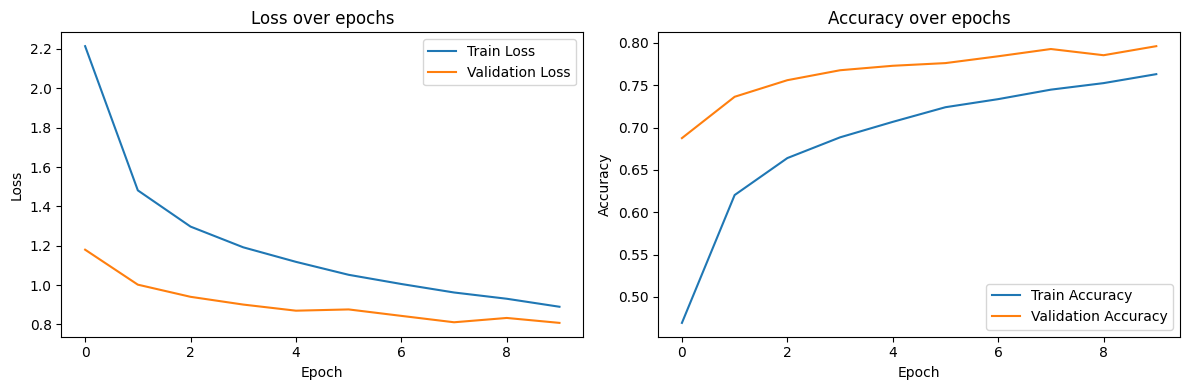

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

<div style="text-align: left; font-family: 'Roboto', sans-serif; padding: 20px; font-size: 30px; font-weight: bold; color: #FF5733;">
  Model Evaluation
</div>
Load the best model and evaluate its performance on the test set.

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

test_corrects = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Testing'):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with autocast():
            outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        test_corrects += torch.sum(preds == labels.data)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = test_corrects.double() / len(test_dataset)
print(f'Test Accuracy: {test_acc:.4f}')

Testing:   0%|          | 0/85 [00:00<?, ?it/s]

Test Accuracy: 0.8401


<div style="text-align: left; font-family: 'Roboto', sans-serif; padding: 20px; font-size: 30px; font-weight: bold; color: #FF5733;">
  Confusion Matrix
</div>
Generate and visualize the confusion matrix for the test set.

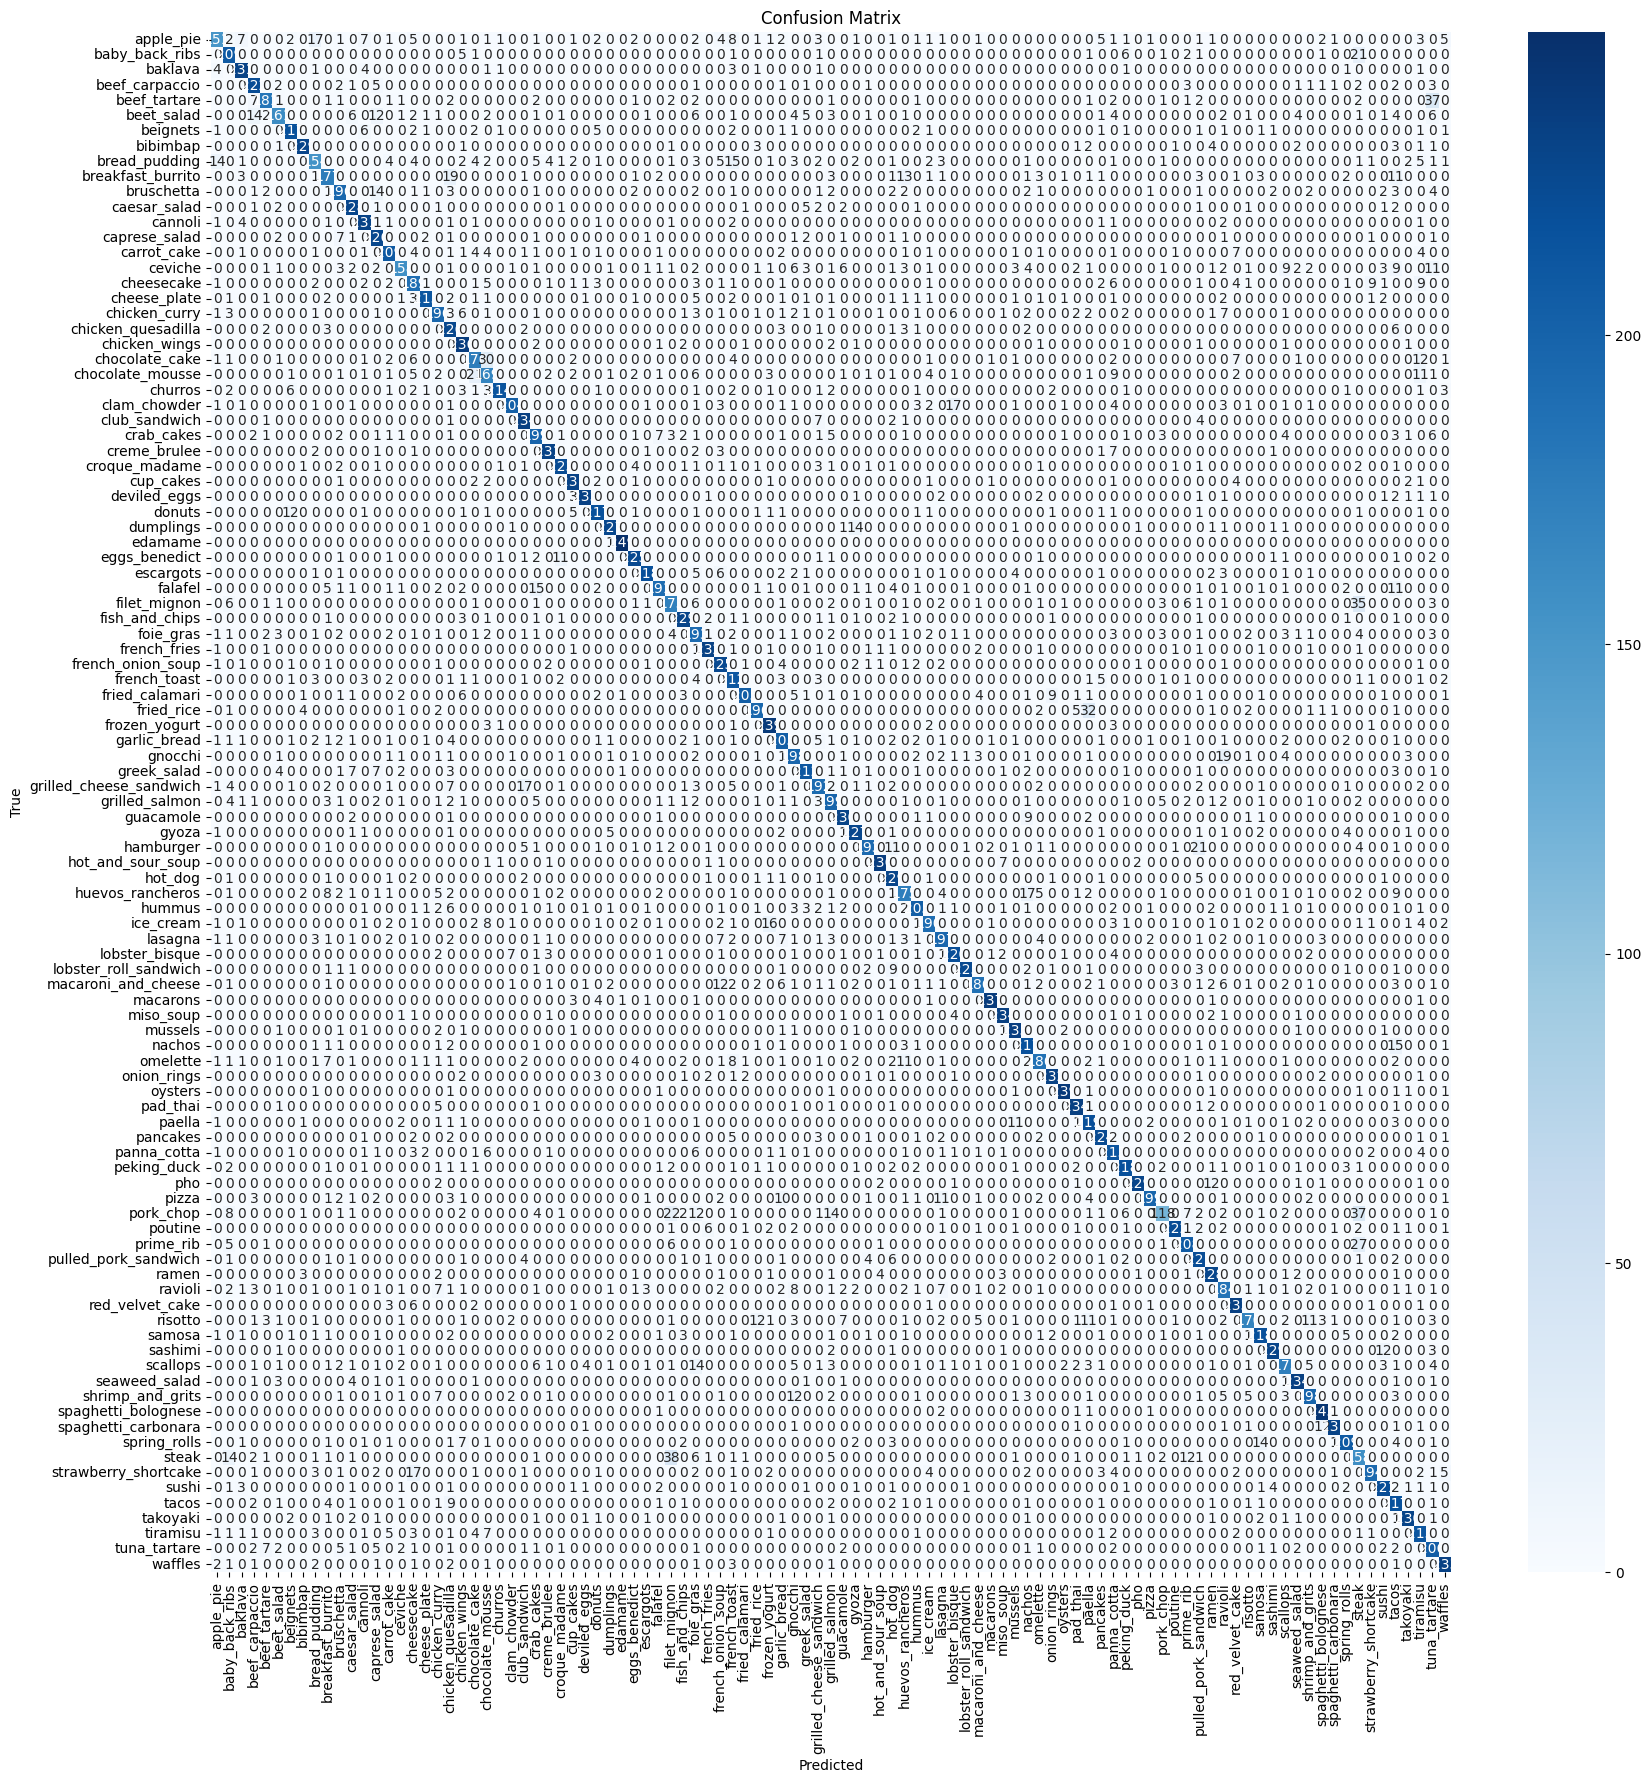

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

<link href="https://fonts.googleapis.com/css2?family=Montserrat:wght@300;400;500&display=swap" rel="stylesheet">

<div style="text-align: center; font-family: 'Roboto', sans-serif; padding: 20px; font-size: 36px; font-weight: bold; color: #FF5733;">
CONCLUSION
</div>

<div style="font-family: 'Roboto', sans-serif; padding: 20px; line-height: 1.6; color: #333;">
  
  <p style="font-size: 16px; font-weight: 300;">
    This project successfully tackled food classification using deep learning techniques, specifically leveraging the <strong>EfficientNet-B0</strong> model for image classification. The model accurately identified various food items from images within the <strong>Food-101</strong> dataset, achieving a test accuracy of <strong>84.01%</strong> and a validation accuracy of <strong>78.55%</strong> after 10 epochs of training. These results highlight the effectiveness of the model in real-world food recognition tasks.
  </p>

  <h2 style="color: #FF5733; font-weight: bold;">Key Insights:</h2>
  <ul style="font-size: 16px; font-weight: 400; margin-left: 20px;">
    <li><strong>EfficientNet-B0</strong> demonstrated strong performance in classifying 101 different food categories, showcasing its capability for image analysis tasks.</li>
    <li>The model's architecture facilitated efficient training and inference, benefiting from transfer learning and pre-trained weights, which improved its accuracy in identifying food items.</li>
    <li>The training metrics indicated an improvement in accuracy and a decrease in loss over the training epochs, reflecting the model's learning capability and the effectiveness of the chosen learning rate schedule.</li>
  </ul>

  <h2 style="color: #FF5733; font-weight: bold;">Model Evaluation:</h2>
  <ul style="font-size: 16px; font-weight: 400; margin-left: 20px;">
    <li><strong>Final Validation Loss:</strong> 0.8328</li>
    <li><strong>Final Validation Accuracy:</strong> 78.55%</li>
    <li><strong>Test Accuracy:</strong> 84.01%</li>
  </ul>

  <h2 style="color: #FF5733; font-weight: bold;">Challenges and Recommendations:</h2>
  <ul style="font-size: 16px; font-weight: 400; margin-left: 20px;">
    <li><strong>Generalization Concerns:</strong> The model showed satisfactory performance on training and validation sets but may encounter challenges with unseen data. Employing additional regularization techniques or enhancing the validation set with diverse food samples could help mitigate overfitting.</li>
    <li><strong>Model Optimization:</strong> While the model's performance was solid, further exploration into hyperparameter tuning and advanced techniques could improve results. Experimenting with different learning rate schedules, incorporating techniques like data augmentation, or exploring other state-of-the-art architectures may lead to enhanced performance.</li>
  </ul>

</div>
